In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from math import sqrt

from datetime import datetime
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import acquire
import prepare

# Exercises
Using saas.csv or log data from API usage or store_item_sales

In [2]:
df = pd.read_csv('saas.csv')

In [3]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
df.isna().sum()

Month_Invoiced       0
Customer_Id          0
Invoice_Id           0
Subscription_Type    0
Amount               0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
Month_Invoiced       790458 non-null object
Customer_Id          790458 non-null int64
Invoice_Id           790458 non-null int64
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [6]:
df.Invoice_Id.nunique()

790458

In [7]:
# converting month_invoiced to a datetime
df['ds'] = pd.to_datetime(df['Month_Invoiced'])
# converting customer id and invoice id into objects
df['Customer_Id'] = df.Customer_Id.astype(object)
df['Invoice_Id'] = df.Invoice_Id.astype(object)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 6 columns):
Month_Invoiced       790458 non-null object
Customer_Id          790458 non-null object
Invoice_Id           790458 non-null object
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
ds                   790458 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 36.2+ MB


1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [9]:
df = df.sort_values('ds').set_index('ds')

In [10]:
df = pd.DataFrame(df.resample("M").Amount.sum())

In [11]:
train_size = int(len(df) * .8)
test_size = int(len(df) - train_size)

train = df[: train_size]
test = df[train_size:]

In [12]:
print(train_size)
print(test_size) 



38
10


In [13]:
train.shape, test.shape

((38, 1), (10, 1))

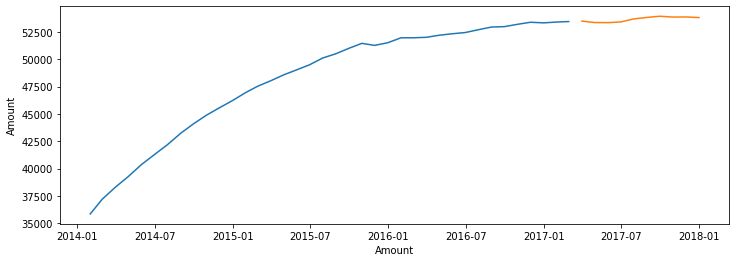

In [14]:
# Validate our train/ test
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.xlabel(col)
    plt.show()

2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average

In [15]:
amount = round(train['Amount'].mean(), 2)

def prediction():
    yhat_df = pd.DataFrame({'Amount': [amount],
                           }, index= test.index)
    return yhat_df

yhat_df = prediction()

In [16]:
yhat_df.head(2)

,Amount
ds,
2017-03-31,48206.18
2017-04-30,48206.18


In [17]:
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

In [18]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(test[target_var], yhat_df[target_var])), 0)
    return rmse

In [19]:
# maggies plot & eval function
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Amount -- RMSE: 5450


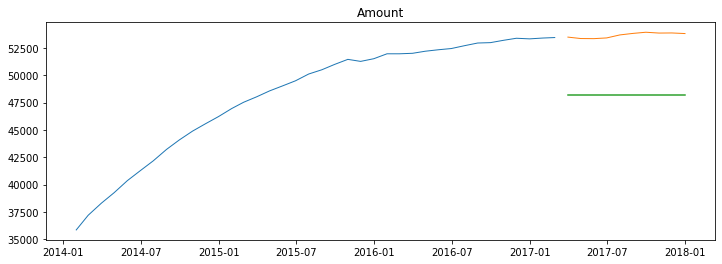

In [20]:
# plot actual .vs. predicted
for col in train.columns:
    plot_and_eval(col)
    

In [26]:
eval_df

,model_type,target_var,rmse
0,simple average,Amount,5450.0


- Moving Average

In [27]:
# compute a 30 day rolling average
period = 30

amount = round(train.Amount.rolling(period).mean().iloc[-1],2)

yhat_df = prediction()
yhat_df.head()


,Amount
ds,
2017-03-31,50475.17
2017-04-30,50475.17
2017-05-31,50475.17
2017-06-30,50475.17
2017-07-31,50475.17


Amount -- RMSE: 3184


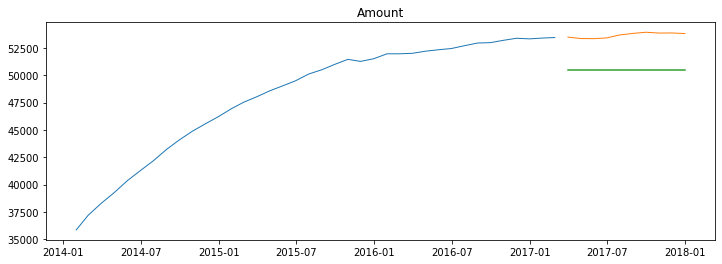

In [28]:
# plot actual .vs. predicted
for col in train.columns:
    plot_and_eval(col)

In [29]:
#evaluate
for col in train.columns:
    eval_df = append_eval_df(model_type = "Moving Average", target_var=col)

In [30]:
eval_df

,model_type,target_var,rmse
0,simple average,Amount,5450.0
1,Moving Average,Amount,3184.0


- Holt's Linear Trend Model

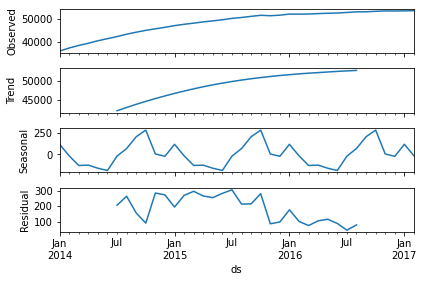

In [38]:
# seasonal decomp
sm.tsa.seasonal_decompose(train['Amount'].resample('M').mean()).\
plot()
None

In [63]:
# predictions
for col in train.columns:
    # create object
    model = Holt(train[col], exponential = True)
    # fit model
    model = model.fit(smoothing_level = .28, smoothing_slope = .18,
                     optimized = True)
    yhat_items = model.predict(start = test.index[0], end = test.\
                               index[-1])
    yhat_df[col] = round(yhat_items, 2)
    
    

In [64]:
yhat_df.head()

,Amount
ds,
2017-03-31,53702.45
2017-04-30,53806.35
2017-05-31,53910.45
2017-06-30,54014.75
2017-07-31,54119.25


Amount -- RMSE: 546


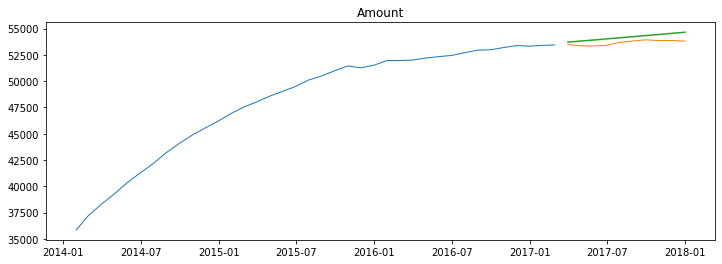

In [65]:
# plot actual .vs. predicted

for col in train.columns:
    plot_and_eval(col)

In [66]:
# Evaluate
for col in train.columns:
    eval_df = append_eval_df(model_type = "Holts", target_var=col)

In [67]:
eval_df

,model_type,target_var,rmse
0,simple average,Amount,5450.0
1,Moving Average,Amount,3184.0
2,Holts,Amount,546.0


Optional: Using store item demand

1. Predict 2018 total monthly sales for a single store and/or item by creating a model using prophet.

In [68]:
df = prepare.prep_store_data()

In [71]:
from fbprophet import Prophet
df.reset_index()
df['ds'] = df['Date']
df['ds'].sort_values('ds').set_index('ds')

ModuleNotFoundError: No module named 'fbprophet'

2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).

3. Plot the 2018 monthly sales predictions.